### Build up features, join to clusters

In [1]:
import numpy as np
import os, sys, json
import PIL
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')
%load_ext autoreload
%autoreload 2

from modules.overlaputils import foo

crop_dir = '../../../rf-chess-data/cropped_verify/'

In [2]:
!ls ../data/rf-annotate/

data_aug_v1.csv  data_v1.1.csv	data_v1.csv


In [3]:
!ls ../../../rf-chess-data/

cropped_v1	eda_1.ipynb  roboflow	 verify.files
cropped_verify	eda_2.ipynb  v1.1.files


In [33]:
train_path

Path('../../../rf-chess-data/cropped_v1')

In [35]:
train_path.ls()[:4]

(#4) [Path('../../../rf-chess-data/cropped_v1/00000_white-pawn.jpg'),Path('../../../rf-chess-data/cropped_v1/00001_black-queen.jpg'),Path('../../../rf-chess-data/cropped_v1/00002_black-pawn.jpg'),Path('../../../rf-chess-data/cropped_v1/00003_white-pawn.jpg')]

### Setup Twin Pairs

In [4]:
df = pd.read_csv('../data/rf-annotate/data_v1.csv')  # '../data/rf-annotate/data_v1.1.csv'
df['bbox'] = df['bbox'].map(lambda x: literal_eval(x))

In [5]:
bq = foo(df, 'black-queen', b_ret=True)
            #crop_dir='../../../rf-chess-data/cropped_verify/',

bq.shape

# bq.head(3)

(87, 17)

In [6]:
amts = bq.groupby('twin_set_cluster_obj').agg('count').iloc[:,1]
# amts

In [7]:
max_show = 99 
matched = amts[amts > 1]
unmatched = amts[amts == 1]

iters = matched.sort_values(ascending=False).index[:max_show]

In [8]:
iters

Index(['[7, 11, 13, 14, 21, 23, 28, 40, 50, 51, 52, 54, 56, 62, 63, 70, 79, 81, 83]',
       '[2, 18, 29, 37, 38, 46, 48, 57, 59, 66, 67, 72, 73, 78]',
       '[5, 6, 16, 20, 30, 32, 33, 39, 47, 60, 69, 86]',
       '[1, 4, 8, 10, 22, 43, 44, 53, 65, 68, 75, 84]',
       '[9, 17, 19, 35, 55, 71, 85]', '[3, 24, 26]', '[45, 58]', '[42, 49]',
       '[27, 74]'],
      dtype='object', name='twin_set_cluster_obj')

In [9]:
literal_eval(iters[0])

[7, 11, 13, 14, 21, 23, 28, 40, 50, 51, 52, 54, 56, 62, 63, 70, 79, 81, 83]

In [10]:
bq.iloc[:4, 13:]

,twin_sets,twin_sets_obj,twin_set_cluster,twin_set_cluster_obj
1,[0],[0],[0],[0]
19,"[1, 4, 8, 10, 22, 43, 44, 53, 65, 68, 75, 84]","[1, 4, 8, 10, 22, 43, 44, 53, 65, 68, 75, 84]","[1, 4, 8, 10, 22, 43, 44, 53, 65, 68, 75, 84]","[1, 4, 8, 10, 22, 43, 44, 53, 65, 68, 75, 84]"
83,"[2, 67]","[2, 67]","[2, 18, 29, 37, 38, 46, 48, 57, 59, 66, 67, 72...","[2, 18, 29, 37, 38, 46, 48, 57, 59, 66, 67, 72..."
188,"[3, 24, 26]","[3, 24, 26]","[3, 24, 26]","[3, 24, 26]"


### Setup Data / Learner

In [11]:
import torch
from fastai.vision.all import *

In [12]:
def piece_class_parse(fn): 
    fn = fn.split('_')[1]
    fn = fn.split('.')[0]
    return fn

train_path = Path('../../../rf-chess-data/cropped_v1/')

Crop = Resize(128, ResizeMethod.Pad, pad_mode='reflection')

train_dl = ImageDataLoaders.from_name_func(
                    
                    train_path, 
                    get_image_files(train_path),                 
                    label_func=piece_class_parse, 
                    item_tfms=Crop,
                    
                    # these are for an evaluation run
                    shuffle_train=False,
                    valid_pct=.0,
                    drop_last=False,
                    num_workers=0,
                    bs=16,
                    )

In [13]:
learn = cnn_learner(train_dl, resnet50, metrics=[], normalize=False)

PATH = '../models/base-learner-6.pth'

model = learn.model
model.load_state_dict(torch.load(PATH))
model.eval();
learn.model = model

In [14]:
new_model = torch.nn.modules.container.Sequential(model[0], model[1][:2])
learn.model = new_model

### Run all observations to create features
Note the order between this and the cropping

In [15]:
train = train_dl[0]

In [57]:
items = train.items.copy()
idxs  = train.get_idxs().copy()

In [17]:
num_batches = len(train.items) / train.bs
num_batches

179.375

In [18]:
# counter = 0
# for x,y in train:
#     counter += 1
#     if counter > 50: break
# counter

In [19]:
counter = 0
y_all = torch.tensor([])
feats_all = torch.tensor([])

In [20]:
for x,y in train:
    
    _feats = new_model(x)
    
    y_all =     torch.cat((y_all, y))
    feats_all = torch.cat((feats_all, _feats.detach()))
    
    counter += 1
    print(counter)
    #if counter > 10: break
    if counter > int(num_batches) + 1: break
counter

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180


180

In [21]:
feats_all.shape

torch.Size([2870, 4096])

In [22]:
y_all.shape

torch.Size([2870])

#### Build df_feats to join

In [84]:
df_items = pd.DataFrame(items, columns=['fn'])

df_feats_all = pd.DataFrame(
                feats_all, 
                columns=['f'+str(i) for i in range(feats_all.shape[1])]
               )

df_y_all = pd.DataFrame(y_all, columns=['y'])

In [85]:
df_feats = pd.concat((df_items, df_y_all, df_feats_all), axis=1)

df_feats['y']           = df_feats['y'].astype('int')
df_feats                = df_feats.sort_values(by='fn')
df_feats['feats_index'] = df_feats.index
df_feats.reset_index(inplace=True)
df_feats['crop_index'] = df_feats.index

In [243]:
df_feats.to_csv('../data/feats-df/feats-2.csv', index=False)

#### Build group_df to join

In [86]:
df = pd.read_csv('../data/rf-annotate/data_v1.csv')  # '../data/rf-annotate/data_v1.1.csv'
df['bbox'] = df['bbox'].map(lambda x: literal_eval(x))

cluster_df = foo(df, 'black-queen', b_ret=True)
            #crop_dir='../../../rf-chess-data/cropped_verify/',

cluster_df.shape

(87, 17)

In [87]:
amts = bq.groupby('twin_set_cluster_obj').agg('count').iloc[:,1]

matched = amts[amts > 1]
unmatched = amts[amts == 1]

iters = matched.sort_values(ascending=False).index

In [88]:
clusters = [literal_eval(e) for e in iters]
clusters

[[7, 11, 13, 14, 21, 23, 28, 40, 50, 51, 52, 54, 56, 62, 63, 70, 79, 81, 83],
 [2, 18, 29, 37, 38, 46, 48, 57, 59, 66, 67, 72, 73, 78],
 [5, 6, 16, 20, 30, 32, 33, 39, 47, 60, 69, 86],
 [1, 4, 8, 10, 22, 43, 44, 53, 65, 68, 75, 84],
 [9, 17, 19, 35, 55, 71, 85],
 [3, 24, 26],
 [45, 58],
 [42, 49],
 [27, 74]]

In [89]:
group_df = bq.copy()

group_df['crop_index'] = group_df.index
group_df.reset_index(inplace=True)
group_df['group_index'] = group_df.index

#### join_df

In [115]:
join_df = pd.merge(left=group_df, right=df_feats, on=['crop_index'], how='left')

In [116]:
join_df.shape

(87, 4120)

### PCA

In [210]:
from sklearn.decomposition import PCA

N_random = 200
xi = np.random.choice(range(df_feats_all.shape[0]), N_random).tolist()

pca = PCA(n_components=12)
pca.fit(df_feats.iloc[xi,3:-2])

PCA(n_components=12)

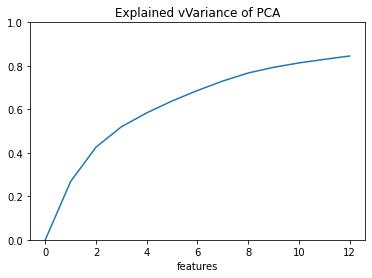

In [249]:
tmp = [0] + pca.explained_variance_ratio_.cumsum().tolist()
plt.plot(tmp); plt.ylim(0,1); plt.title('Explained vVariance of PCA'); plt.xlabel('features');

In [211]:
random_obs_t = pca.transform(df_feats.iloc[xi,3:-2])
random_obs_meta = df_feats.iloc[xi,:].loc[:,['y']]

In [212]:
player_color = [1 if e <= 5 else 0 for e in random_obs_meta['y'].tolist()]
d_color = ['orange', 'blue']
player_color = [d_color[e] for e in player_color]

#### Simple Plotting

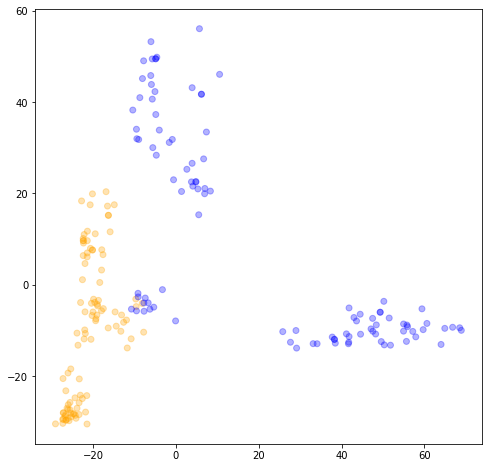

In [213]:
plt.figure(figsize=(8,8))
plt.scatter(random_obs_t[:,0], random_obs_t[:,1], c=player_color, alpha=0.3);

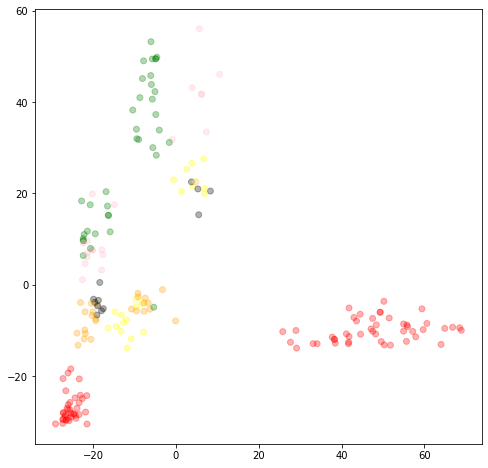

In [214]:
vocab = list(train_dl.vocab).copy()

vocab_piece = [e.split('-')[-1] for e in vocab]

d_color = {'knight': 'orange', 
           'rook':  'green',
           'pawn': 'red',
           'queen': 'black',
           'king':  'yellow',
           'bishop': 'pink',
          }

piece_color = [d_color[vocab_piece[e]] for e in random_obs_meta['y'].tolist()]

plt.figure(figsize=(8,8))
plt.scatter(random_obs_t[:,0], random_obs_t[:,1], c=piece_color, alpha=0.3);

In [215]:
cluster_ind = 0
this_cluster = clusters[cluster_ind]
this_cluster

[7, 11, 13, 14, 21, 23, 28, 40, 50, 51, 52, 54, 56, 62, 63, 70, 79, 81, 83]

In [216]:
x_in = join_df['group_index'].isin(this_cluster)
x_out = x_in.map(lambda x: not(x))

in_cluster =  join_df[x_in]
out_cluster = join_df[x_out]

n_features = 4096
fcols = ['f' + str(i) for i in range(n_features)]

in_t =  pca.transform(in_cluster.loc[:,fcols])
out_t = pca.transform(out_cluster.loc[:,fcols])
                    

### Final Display Graph
Results: clusters of pseudo-duplicates are not revealed with pca 1+2 clusters.

This indicates that comparing the full feature set from a trained CNN's backbone does not help us identify images of simlarity

In [234]:
from matplotlib import lines as mlines

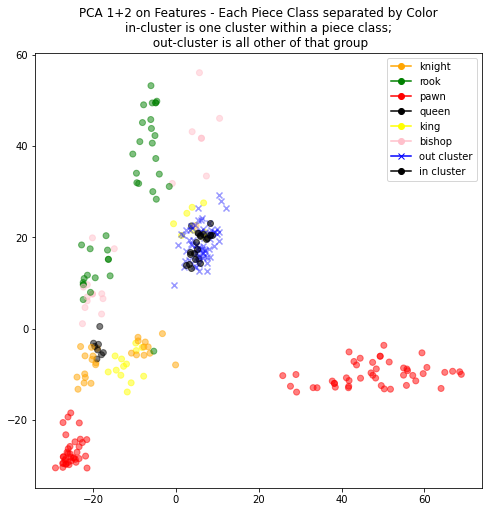

In [236]:
piece_color = [d_color[vocab_piece[e]] for e in random_obs_meta['y'].tolist()]

plt.figure(figsize=(8,8))
plt.scatter(random_obs_t[:,0], random_obs_t[:,1], c=piece_color, alpha=0.5);
plt.scatter(out_t[:,0], out_t[:,1], c='blue', alpha=0.4, marker='x')
plt.scatter(in_t[:,0], in_t[:,1], c='black', alpha=0.6, marker='o');

title =  'PCA 1+2 on Features - Each Piece Class separated by Color\n'
title += 'in-cluster is one cluster within a piece class;\n out-cluster is all other of that group'
plt.title(title);

handles = [mlines.Line2D([0],[0], marker='o', c=color) for color in d_color.values()]
l_keys = [str(e) for e in d_color.keys()]
handles += [mlines.Line2D([0],[0], marker='x', c='blue') ]
handles += [mlines.Line2D([0],[0], marker='o', c='black')]
l_keys += ['out cluster', 'in cluster']
plt.legend(handles, l_keys);